# Projet d'Analyse Hydro-Océanographique 
### Etude de cas: Carte nautique entre Casablanca et Rabat 

## 1. Préparation de l'environnement

In [35]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})
plt.rcParams['figure.figsize'] = (12, 8)
RAW_DIR = os.path.join('..', 'data', 'raw')
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
os.makedirs(PROCESSED_DIR, exist_ok=True)

## 2. Chargement des données brutes

In [36]:
#Ouveture des trois fichiers NetCDF pour pouvoir les exploiter (vent, courants, bathymétrie).
files = os.listdir(RAW_DIR)
print('Fichiers dans data/raw :', files)

wind = xr.open_dataset(os.path.join(RAW_DIR, 'cdsWind.nc'))
currents = xr.open_dataset(os.path.join(RAW_DIR, 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1748321230089.nc'))
bathymetry = xr.open_dataset(os.path.join(RAW_DIR, 'gebco_2024.nc'))
print(wind)
print(currents)
print(bathymetry)

Fichiers dans data/raw : ['cdsWind.nc', 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1748321230089.nc', 'gebco_2024.nc']
<xarray.Dataset>
Dimensions:     (valid_time: 744, latitude: 3, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-05-01 ... 2024-05-31T23:00:00
  * latitude    (latitude) float64 34.0 33.75 33.5
  * longitude   (longitude) float64 -7.5 -7.25 -7.0 -6.75 -6.5
    expver      (valid_time) object ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 ...
    v10         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-27T18:11 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset>
Dimensions:    (time: 

## 3. Ingestion et conversion en DataFrame

In [37]:
# On transforme les données de vent en DataFrame (tableau) et on supprime les lignes vides.
wind_df = wind.to_dataframe().reset_index().dropna()
print('wind_df shape:', wind_df.shape)

wind_df shape: (11160, 7)


## 4. Prétraitement des données

In [38]:
# 1. On duplique le DataFrame original pour ne pas modifier wind_df directement
df = wind_df.copy()

# 2. Imputation des valeurs manquantes dans chaque colonne numérique
for col in df.select_dtypes(include=np.number):
    # Remplace les NaN par la médiane de la colonne pour conserver la distribution
    df[col].fillna(df[col].median(), inplace=True)

# 3. Encodage des colonnes textuelles (type 'object') en valeurs numériques
for col in df.select_dtypes(include='object'):
    # LabelEncoder transforme chaque catégorie unique en un entier
    df[col] = LabelEncoder().fit_transform(df[col])

# 4. Préparation de la normalisation
scaler = StandardScaler()

# 5. On identifie toutes les colonnes numériques après encodage
num_cols = df.select_dtypes(include=np.number).columns

# 6. Application du StandardScaler :
#    - centre chaque variable à une moyenne de 0
#    - échelonne chaque variable pour un écart-type de 1
df[num_cols] = scaler.fit_transform(df[num_cols])

# 7. Affiche les premières lignes du DataFrame traité pour vérifier les transformations
df.head()


C:\Users\zaineb\AppData\Local\Temp\ipykernel_5708\2469237043.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,valid_time,latitude,longitude,number,expver,u10,v10
0,2024-05-01,1.224745,-1.414214,0.0,0.0,1.117279,0.563524
1,2024-05-01,1.224745,-0.707107,0.0,0.0,0.582775,1.279074
2,2024-05-01,1.224745,0.000000,0.0,0.0,0.105177,1.644504
3,2024-05-01,1.224745,0.707107,0.0,0.0,-0.292483,1.888453
4,2024-05-01,1.224745,1.414214,0.0,0.0,-0.442876,2.113637


## 5. Analyse exploratoire

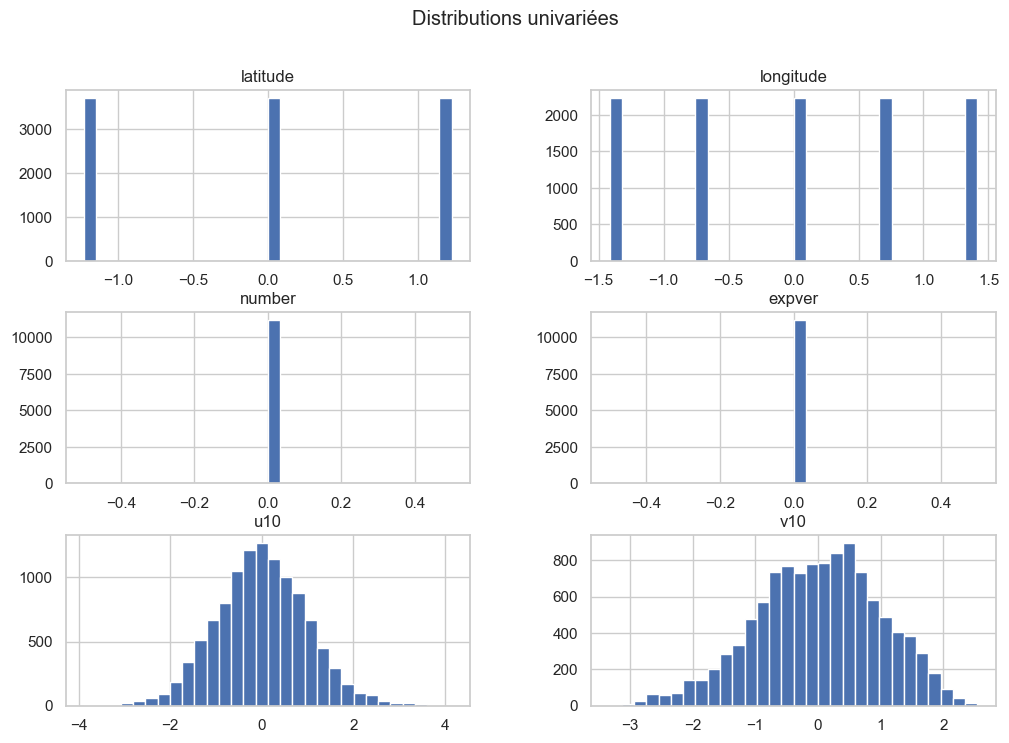

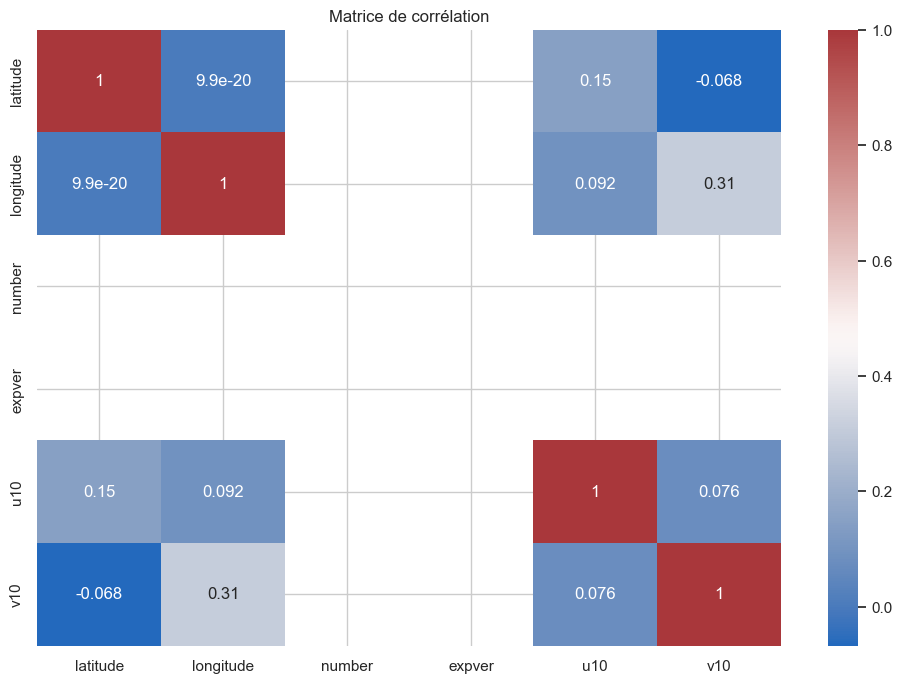

In [39]:
# Trace des histogrammes pour chaque variable numérique
# bins=30 définit le nombre de classes (barres) pour l’histogramme
df[num_cols].hist(bins=30)

# Titre global de la figure
plt.suptitle('Distributions univariées')

# Affichage du graphique
plt.show()

# Calcul de la matrice de corrélation entre toutes les variables numériques
corr = df[num_cols].corr()

# Affichage de la heatmap de corrélation
# annot=True pour afficher les coefficients à l’intérieur des cases
# cmap='vlag' choisit une palette de couleurs allant du violet (négatif) au vert (positif)
sns.heatmap(corr, annot=True, cmap='vlag')

# Titre pour la seconde figure
plt.title('Matrice de corrélation')

# Affichage du second graphique
plt.show()


## 6. Définition de la cible et équilibrage

In [40]:
# 1. Création de la variable cible ("target")  
#    On définit un seuil : le 3ᵉ quartile (75ᵉ percentile) de la vitesse du vent (u10)  
threshold = df['u10'].quantile(0.75)  
#    Pour chaque ligne, target = 1 si u10 > threshold, sinon 0  
df['target'] = (df['u10'] > threshold).astype(int)

# 2. Préparation des features (X) et de la cible (y)  
#    On retire la colonne 'u10' (utilisée pour créer target) et 'target'  
X = df.drop(columns=['u10', 'target'])  
#    On ne garde que les colonnes numériques, car SMOTE et les modèles ML travaillent sur des nombres  
X = X.select_dtypes(include=[np.number])  
#    y est la série des valeurs 0/1 à prédire  
y = df['target']

# 3. Équilibrage des classes avec SMOTE  
try:
    # Import de SMOTE (génère des exemples synthétiques de la classe minoritaire)
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    # fit_resample renvoie X et y rééquilibrés
    X_res, y_res = smote.fit_resample(X, y)
    # Affichage de la nouvelle répartition des classes
    print('SMOTE appliqué, nouvelle répartition :')
    print(pd.Series(y_res).value_counts())
    # On remplace X et y par leurs versions rééquilibrées
    X, y = X_res, y_res

except ImportError:
    # Message d’erreur si la bibliothèque n’est pas installée
    print('imbalanced-learn non installé, installez via pip install imbalanced-learn')


SMOTE appliqué, nouvelle répartition :
target
1    8370
0    8370
Name: count, dtype: int64


## 7. Modélisation avec arbre de décision

Accuracy: 0.6415770609318996
              precision    recall  f1-score   support

           0       0.71      0.50      0.59      1711
           1       0.60      0.79      0.68      1637

    accuracy                           0.64      3348
   macro avg       0.66      0.64      0.64      3348
weighted avg       0.66      0.64      0.63      3348



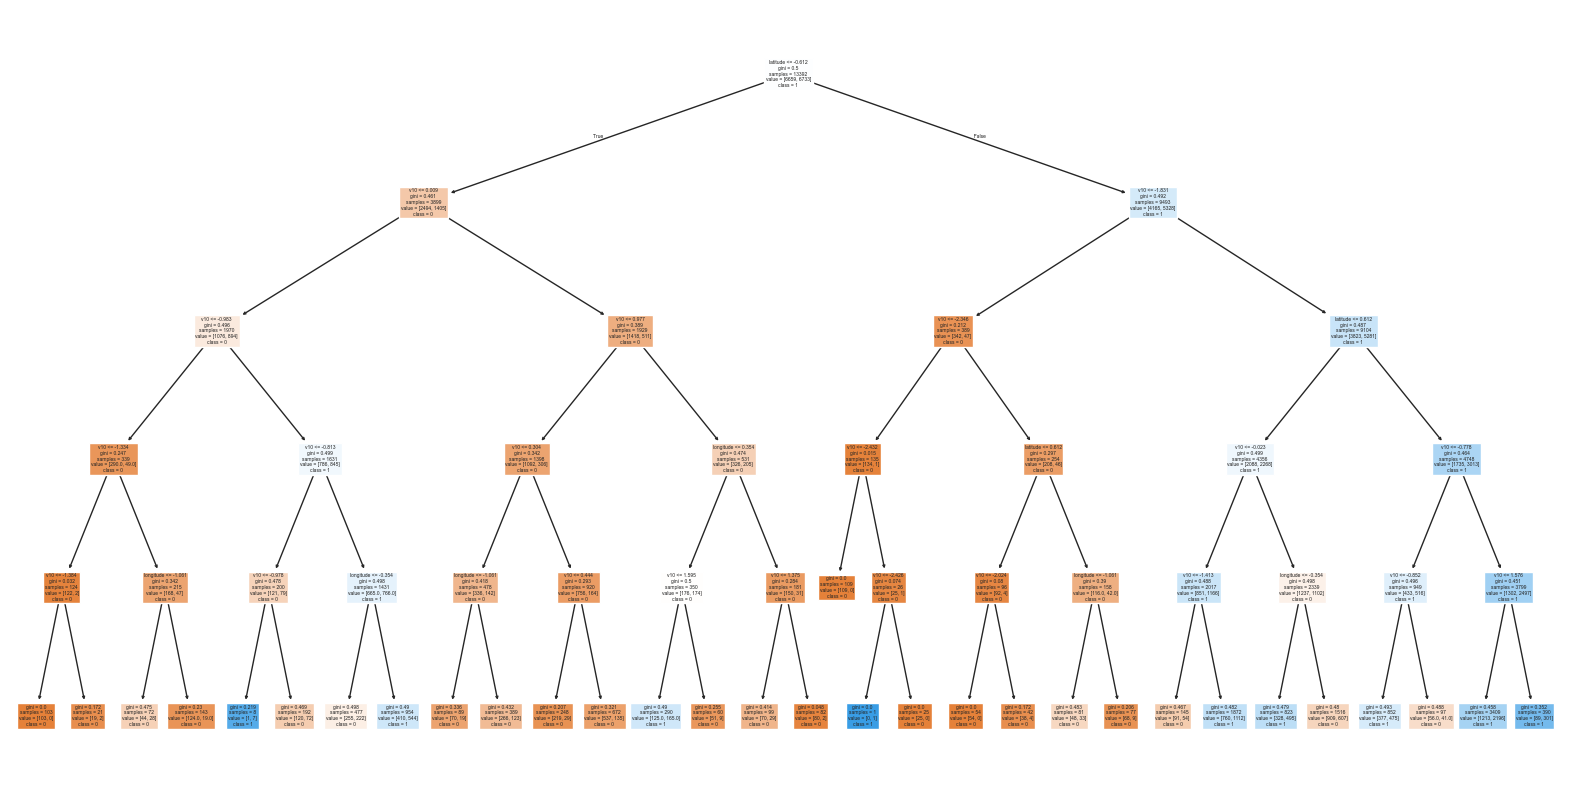

In [41]:
# 1. Séparation des données en ensembles d'entraînement et de test
#    test_size=0.2 → 20 % des données réservées pour l’évaluation
#    random_state=42 pour garantir la reproductibilité
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialisation du classifieur Decision Tree
#    max_depth=5 limite la profondeur de l’arbre pour éviter l’overfitting
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# 3. Entraînement du modèle sur l’ensemble d’entraînement
dt.fit(Xtr, ytr)

# 4. Prédiction sur l’ensemble de test
pred = dt.predict(Xte)

# 5. Calcul et affichage de l’accuracy (taux de bonnes prédictions)
print('Accuracy:', accuracy_score(yte, pred))

# 6. Rapport de classification détaillé :
#    - precision, recall et f1-score pour chaque classe
#    - support = nombre d’échantillons réels par classe
print(classification_report(yte, pred))

# 7. Visualisation de l’arbre de décision
#    figsize pour contrôler la taille de la figure
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X.columns,   # noms des features utilisées
    class_names=['0','1'],     # étiquettes des classes
    filled=True                # colorie les nœuds selon la classe majoritaire
)
plt.show()


## 8. Prochaines étapes

- Intégrer courants & bathymétrie dans le DataFrame
- Tester les réseaux bayésiens et clustering hiérarchique
- Ajouter l'implémentation deep learning
- Documenter le flux dans Orange (.ows)
- Exporter le DataFrame final dans data/processed/processed_data.csv